<a href="https://colab.research.google.com/github/Rogerio-mack/CIMATEC-Tecnicas-de-Construcao-de-Algoritmos-Quanticos-UA3-UA4/blob/main/TSP_QAnnealing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIMATEC - Técnicas de Construção de Algoritmos Quânticos
---
### UA 3 e UA 4 - Hands On (Parte A, TSP Quantum Annealing)

### **GRUPO 7**

- Bruno Zolotareff dos Santos;
- Lihoy Aguiar Bellissimo;
- Marcos Aurélio Duarte Carvalho;
- Rafael Marin Machado de Souza;  
- Rogério de Oliveira;
- Thiago Soares Assimos;


# Conteúdo

Este notebook implementa uma solução de Quantum Annealing para um problema do Caixeiro Viajante com 5 nós como parte da tarefa UA 3 e UA 4 - Hands On (Parte A, TSP Quantum Annealing).

Aqui são implementadas e comparardas as soluções:

- Clássica Exata (força bruta)
- Quantum Annealing (QUBO + SA simulado com o pacote DWave)
- Simulated Annealing Clássico (permutações)


# Installs and Imports

In [1]:
!pip install dwave-ocean-sdk dwave-neal networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.5/167.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import itertools
import networkx as nx
import matplotlib.pyplot as plt

import dimod
from dimod import SimulatedAnnealingSampler


# Definião do Grafo TSP

In [3]:
N = 5

dist = np.array([
    [0, 2, 9, 10, 7],
    [2, 0, 6, 4, 3],
    [9, 6, 0, 8, 5],
    [10, 4, 8, 0, 6],
    [7, 3, 5, 6, 0]
])


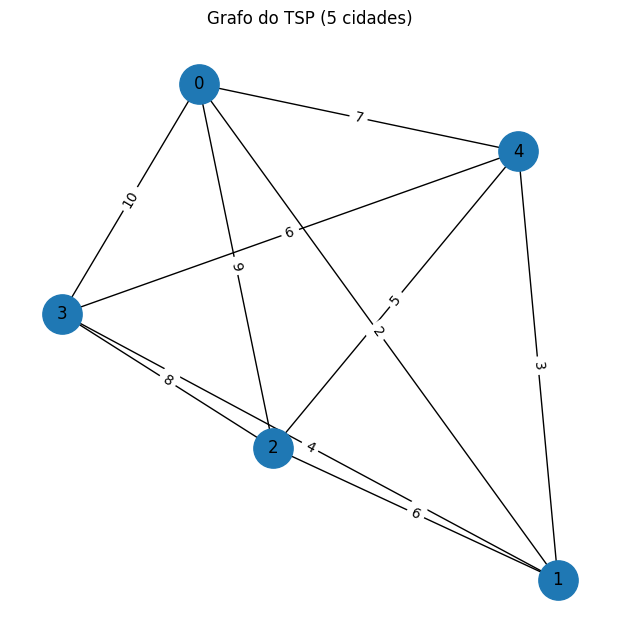

In [4]:
G = nx.complete_graph(N)

for i in range(N):
    for j in range(N):
        if i != j:
            G[i][j]['weight'] = dist[i][j]

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(6,6))
nx.draw(G, pos, with_labels=True, node_size=800)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Grafo do TSP (5 cidades)")
plt.show()


# Solução Clássica Ótima

In [5]:
%%time
def tsp_cost(tour, dist):
    cost = 0
    for i in range(len(tour)):
        cost += dist[tour[i], tour[(i+1) % len(tour)]]
    return cost


best_classical_tour = None
best_classical_cost = np.inf

for perm in itertools.permutations(range(N)):
    cost = tsp_cost(perm, dist)
    if cost < best_classical_cost:
        best_classical_cost = cost
        best_classical_tour = perm

print("Solução clássica ótima:")
print("Tour:", best_classical_tour)
print("Custo:", best_classical_cost)


Solução clássica ótima:
Tour: (0, 1, 3, 2, 4)
Custo: 26
CPU times: user 1.41 ms, sys: 110 µs, total: 1.52 ms
Wall time: 3.73 ms


# Solução Quântica Adiabática

## Construção do Hamiltoniano

In [6]:
def var_index(city, position):
    return city * N + position

Q = {}
A = 10  # penalidade das restrições
B = 1   # peso da função objetivo

for i in range(N):
    for p in range(N):
        Q[(var_index(i,p), var_index(i,p))] = Q.get((var_index(i,p), var_index(i,p)), 0) - A
        for q in range(p+1, N):
            Q[(var_index(i,p), var_index(i,q))] = Q.get((var_index(i,p), var_index(i,q)), 0) + 2*A

for p in range(N):
    for i in range(N):
        Q[(var_index(i,p), var_index(i,p))] = Q.get((var_index(i,p), var_index(i,p)), 0) - A
        for j in range(i+1, N):
            Q[(var_index(i,p), var_index(j,p))] = Q.get((var_index(i,p), var_index(j,p)), 0) + 2*A

for i in range(N):
    for j in range(N):
        if i != j:
            for p in range(N):
                q = (p + 1) % N
                Q[(var_index(i,p), var_index(j,q))] = Q.get(
                    (var_index(i,p), var_index(j,q)), 0
                ) + B * dist[i][j]


In [7]:
%%time
sampler = SimulatedAnnealingSampler()
response = sampler.sample_qubo(Q, num_reads=2000)

best_sample = response.first.sample
best_energy = response.first.energy

quantum_tour = [-1]*N
for i in range(N):
    for p in range(N):
        if best_sample[var_index(i,p)] == 1:
            quantum_tour[p] = i

quantum_cost = tsp_cost(quantum_tour, dist)

print("\nSolução via Quantum Annealing (simulado):")
print("Tour:", quantum_tour)
print("Custo:", quantum_cost)
print("Energia QUBO:", best_energy)



Solução via Quantum Annealing (simulado):
Tour: [0, 2, 4, 3, 1]
Custo: 26
Energia QUBO: -74.0
CPU times: user 8min 31s, sys: 332 ms, total: 8min 31s
Wall time: 8min 41s


## Distribuição das energias

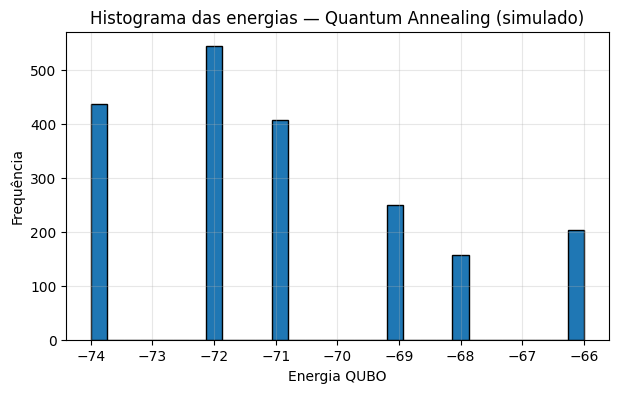

In [8]:
energies = response.record.energy

plt.figure(figsize=(7,4))
plt.hist(energies, bins=30, edgecolor='black')
plt.xlabel("Energia QUBO")
plt.ylabel("Frequência")
plt.title("Histograma das energias — Quantum Annealing (simulado)")
plt.grid(True, alpha=0.3)
plt.show()


# Solução Simulated Annealing Clássica

In [9]:
import random
import math


In [10]:
def simulated_annealing_tsp(
    dist,
    initial_temp=1000,
    cooling_rate=0.995,
    n_iter=20000
):
    N = len(dist)

    # solução inicial aleatória
    current = list(range(N))
    random.shuffle(current)
    current_cost = tsp_cost(current, dist)

    best = current[:]
    best_cost = current_cost

    T = initial_temp

    for _ in range(n_iter):
        # vizinho: swap de duas cidades
        i, j = random.sample(range(N), 2)
        neighbor = current[:]
        neighbor[i], neighbor[j] = neighbor[j], neighbor[i]

        neighbor_cost = tsp_cost(neighbor, dist)
        delta = neighbor_cost - current_cost

        if delta < 0 or random.random() < math.exp(-delta / T):
            current = neighbor
            current_cost = neighbor_cost

            if current_cost < best_cost:
                best = current[:]
                best_cost = current_cost

        T *= cooling_rate

    return best, best_cost


In [11]:
%time
sa_tour, sa_cost = simulated_annealing_tsp(dist)

print("\nSimulated Annealing clássico:")
print("Tour :", sa_tour)
print("Custo:", sa_cost)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs

Simulated Annealing clássico:
Tour : [3, 1, 0, 4, 2]
Custo: 26


# Comparativo Final

In [12]:
print("\n===== COMPARATIVO FINAL =====")

print("\nClássico exato (força bruta):")
print("  Tour :", best_classical_tour)
print("  Custo:", best_classical_cost)

print("\nQuantum Annealing (QUBO + SA simulado):")
print("  Tour :", quantum_tour)
print("  Custo:", quantum_cost)

print("\nSimulated Annealing clássico (permutações):")
print("  Tour :", sa_tour)
print("  Custo:", sa_cost)



===== COMPARATIVO FINAL =====

Clássico exato (força bruta):
  Tour : (0, 1, 3, 2, 4)
  Custo: 26

Quantum Annealing (QUBO + SA simulado):
  Tour : [0, 2, 4, 3, 1]
  Custo: 26

Simulated Annealing clássico (permutações):
  Tour : [3, 1, 0, 4, 2]
  Custo: 26
